In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# %matplotlib inline

In [3]:
trainData = pd.read_csv('datasets/train.csv')
testData = pd.read_csv('datasets/test.csv')

In [4]:
print("Training data size: {}; Test data size: {}".format(len(trainData), len(testData)))

Training data size: 891; Test data size: 418


In [5]:
trainData.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
testData.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [7]:
def mergeData(base, append):
    combined = base.append(append)
    combined.reset_index(inplace = True)
    combined.drop('index', axis = 1, inplace = True)
    return combined

In [8]:
allData = mergeData(trainData, testData)

## Fill In Age Gaps

Several rows have a missing age. To fill the gaps we will find the median of ages based on other passengers with a similar `sex`, `pclass`, and `honorific`.

This is accomplished in several steps.

1. Extract honorific from name.
2. Create a uniform mapping of all the honorifics.
3. Group the data and capture the median based on `sex`, `pclass`, and the mapped `honorific`.
4. Map any passengers that have a missing age to the data from the median.

In [9]:
allData.Name[0:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [10]:
honorifics = set(allData.Name.map(lambda name: name.split(',')[1].split('.')[0].strip()))

In [11]:
allData['Hon'] = allData.Name.map(lambda name: name.split(',')[1].split('.')[0].strip())

In [12]:
honorifics

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [13]:
HONORIFIC_MAP = {
    'Capt': 'Military',
    'Col': 'Military',
    'Don': 'Nobility',
    'Dona': 'Nobility',
    'Dr': 'Doctor',
    'Jonkheer': 'Nobility',
    'Lady': 'Nobility',
    'Major': 'Military',
    'Master': 'Boy',
    'Miss': 'Ms',
    'Mlle': 'Ms',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Ms',
    'Sir': 'Mr',
    'the Countess': 'Nobility'
}

In [14]:
allData.Hon = allData.Hon.map(HONORIFIC_MAP)

In [15]:
allData.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Hon
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Ms
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,Mr
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,Boy
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,Mrs
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,Mrs


In [16]:
grouped_results_by_class = allData.groupby(['Sex', 'Pclass', 'Hon']).median()

In [17]:
grouped_results_by_class

Age      Fare  Parch  PassengerId  SibSp  Survived
Sex    Pclass Hon                                                          
female 1      Doctor    49.0   25.9292    0.0        797.0    0.0       1.0
              Mrs       45.0   78.1125    0.0        853.5    1.0       1.0
              Ms        30.0   99.9625    0.0        529.5    0.0       1.0
              Nobility  39.0   86.5000    0.0        760.0    0.0       1.0
       2      Mrs       30.5   26.0000    0.0        547.0    1.0       1.0
              Ms        20.0   19.5000    0.0        597.0    0.0       1.0
       3      Mrs       31.0   15.5000    1.0        658.0    1.0       0.5
              Ms        18.0    8.0500    0.0        613.0    0.0       0.5
male   1      Boy        6.0  134.5000    2.0        803.0    1.0       1.0
              Doctor    47.0   81.8583    0.0        661.0    1.0       0.5
              Military  53.0   30.5000    0.0        695.0    0.0       0.0
              Mr        42.0   48.3021    0.0        632.5    0.0       0.0
              Nobility  39.0   13.8604    0.0        427.0    0.0       0.0
       2      Boy        2.0   26.0000    1.0        550.0    1.0       1.0
              Doctor    38.5   12.2500    0.0        358.5    0.0       0.0
              Mr        30.0   13.0000    0.0        723.5    0.0       0.0
       3      Boy        6.0   22.3583    1.0        789.0    3.0       0.0
              Mr        26.0    7.8958    0.0        640.5    0.0       0.0

In [18]:
def missingAgeFromSimilarMedian(grouped_median, row):
    return grouped_median['Age'][row.Sex][row.Pclass][row.Hon]

allData.Age = allData.apply(lambda row: missingAgeFromSimilarMedian(grouped_results_by_class, row) if np.isnan(row.Age) else row.Age, axis = 1)

In [19]:
allData.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Hon
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Ms
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
5,26.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,Mr
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,Boy
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,Mrs
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,Mrs


## Missing Fare

Only one passenger has a missing fare, for this we will just use the average for `Pclass 3`

In [20]:
allData.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.275149,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,13.454072,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,26.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,36.500000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [21]:
print(allData[allData.Fare.isnull()])

       Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket Hon  
1043       3  male      0       NaN   3701  Mr  


In [22]:
averageFare = allData[allData['Pclass'] == 3].Fare.mean()
allData = allData.set_value(1043, 'Fare', averageFare)

Now that we've filled the data we need for a training set we will remove the columns we no longer need and normalize the output.

In [23]:
# allData.drop('Name', 1, inplace = True)

## Missing Embarkment

Two passengers are missing their embarkment, we can see they both have the same `Fare` and are of the same `Pclass`. To find the missing `Embarked` we'll take a look at other passengers of the same class that paid a similar fare.

In [24]:
allData[allData.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Hon
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Ms
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs


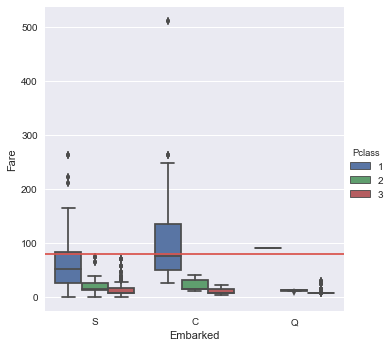

In [25]:
# show the average fare paid for each location embarked
# highlighted by the Pclass
sns.factorplot(
    x = "Embarked",
    y = "Fare",
    hue = "Pclass",
    data = allData[~allData['Embarked'].isnull()],
    kind = "box",
    size = 5)

# draw a horizontal our missing embarkment where the average fare was $80
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [80], sns.xkcd_rgb["pale red"])
plt.show()

In [26]:
COMMON_EMBARKMENT = 'C'

allData = allData.set_value(61, 'Embarked', 'C')
allData = allData.set_value(829, 'Embarked', 'C')

## Prediction

We've filled in our missing data, let's split our training and test sets and see what we can discover!

In [27]:
# split our training and test data
TRAINING_DATA_SPLIT = len(trainData)

betterTrainData = allData[0:TRAINING_DATA_SPLIT]
betterTestData = allData[TRAINING_DATA_SPLIT:]

In [28]:
betterTrainData['SexNormalized'] = pd.factorize(betterTrainData['Sex'])[0]
betterTrainData['HonNormalized'] = pd.factorize(betterTrainData['Hon'])[0]
betterTrainData['EmbarkedNormalized'] = pd.factorize(betterTrainData['Embarked'])[0]

betterTestData['SexNormalized'] = pd.factorize(betterTestData['Sex'])[0]
betterTestData['HonNormalized'] = pd.factorize(betterTestData['Hon'])[0]
betterTestData['EmbarkedNormalized'] = pd.factorize(betterTestData['Embarked'])[0]

/Users/baylorrae/.virtualenvs/titanic_ve/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/baylorrae/.virtualenvs/titanic_ve/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/baylorrae/.virtualenvs/titanic_ve/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [29]:
FEATURES = ['Age', 'EmbarkedNormalized', 'Fare', 'Parch', 'Pclass', 'SexNormalized', 'HonNormalized']

In [30]:
classifier = RandomForestClassifier(n_jobs=200)
classifier.fit(betterTrainData[FEATURES], betterTrainData.Survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=200, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [31]:
features = pd.DataFrame()
features['feature'] = FEATURES
features['importance'] = classifier.feature_importances_
features.sort_values('importance', ascending = False)

,feature,importance
6,HonNormalized,0.265586
2,Fare,0.253905
0,Age,0.214459
5,SexNormalized,0.103989
4,Pclass,0.095406
3,Parch,0.034300
1,EmbarkedNormalized,0.032354


In [43]:
prediction = classifier.predict(betterTestData[FEATURES])

solution = pd.DataFrame()
solution['PassengerId'] = betterTestData.PassengerId
solution['Survived'] = prediction

solution.to_csv('solution.csv', index = False)

solution

,PassengerId,Survived
891,892,0.0
892,893,1.0
893,894,0.0
894,895,0.0
895,896,0.0
896,897,0.0
897,898,0.0
898,899,0.0
899,900,1.0
900,901,0.0
